# Sentiment Analysis on Amazon Fine Food Reviews

* #### [Part 1. Data Exploration](#part1) 
* #### [Part 2. Data Preparation](#part2) 
* #### [Part 3. Bag of Words](#part3)
* #### [Part 4. Word2Vec](#part4)
* #### [Part 5. LSTM](#part5)
* #### [Part 6. Word Cloud](#part6)



---
<a id="part1"></a>
## Part 1. Data Exploration

In [2]:
import pandas as pd
import numpy as np
import sqlite3

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.pipeline import Pipeline


import re
import nltk
from bs4 import BeautifulSoup
import lxml
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk import sent_tokenize, word_tokenize, pos_tag

import logging
from gensim.models import word2vec
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors

from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Lambda,SpatialDropout1D
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, SimpleRNN, GRU
from keras.preprocessing.text import Tokenizer
from collections import defaultdict
from keras.layers.convolutional import Convolution1D
from keras import backend as K
from keras.layers.embeddings import Embedding

### Load Data

In [3]:



cnx = sqlite3.connect('/home/varuni/Documents/ML-LabProj/amazon-fine-food-reviews/database.sqlite')

df = pd.read_sql_query("SELECT * FROM Reviews", cnx)

### Data Exploration

In [4]:
print("Summary statistics of numerical features : \n", df.describe())

print("\nTotal number of reviews: ",len(df))

print("\nTotal number of unique products: ", len(list(set(df['ProductId']))))

print("\nPercentage of reviews with neutral sentiment : {:.2f}%"\
      .format(df[df['Score']==3]["Score"].count()/len(df)*100))
print("\nPercentage of reviews with positive sentiment : {:.2f}%"\
      .format(df[df['Score']>3]["Score"].count()/len(df)*100))
print("\nPercentage of reviews with negative sentiment : {:.2f}%"\
      .format(df[df['Score']<3]["Score"].count()/len(df)*100))

Summary statistics of numerical features : 
                   Id  HelpfulnessNumerator  HelpfulnessDenominator  \
count  568454.000000         568454.000000            568454.00000   
mean   284227.500000              1.743817                 2.22881   
std    164098.679298              7.636513                 8.28974   
min         1.000000              0.000000                 0.00000   
25%    142114.250000              0.000000                 0.00000   
50%    284227.500000              0.000000                 1.00000   
75%    426340.750000              2.000000                 2.00000   
max    568454.000000            866.000000               923.00000   

               Score          Time  
count  568454.000000  5.684540e+05  
mean        4.183199  1.296257e+09  
std         1.310436  4.804331e+07  
min         1.000000  9.393408e+08  
25%         4.000000  1.271290e+09  
50%         5.000000  1.311120e+09  
75%         5.000000  1.332720e+09  
max         5.000000  1.3512

### Data Visualization 

Text(0,0.5,'Count')

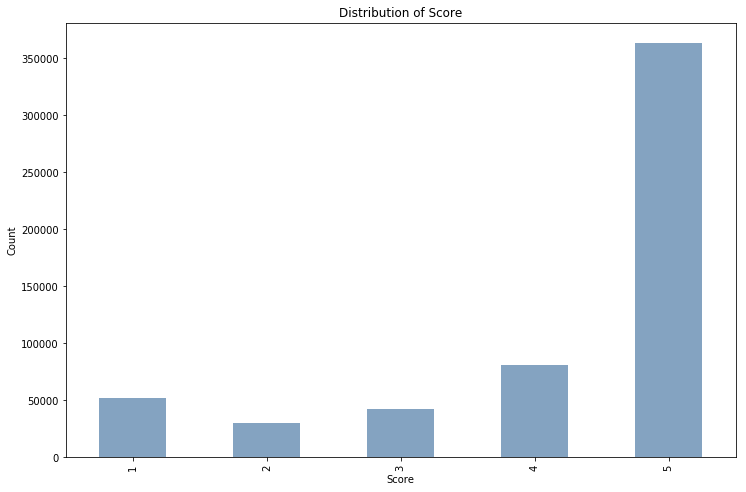

In [5]:
# Plot distribution of rating
plt.figure(figsize=(12,8))
df['Score'].value_counts().sort_index().plot(kind='bar', color=(0.2, 0.4, 0.6, 0.6))
plt.title('Distribution of Score')
plt.xlabel('Score')
plt.ylabel('Count')

Text(0.5,1,'Number of Reviews for Top 50 Products')

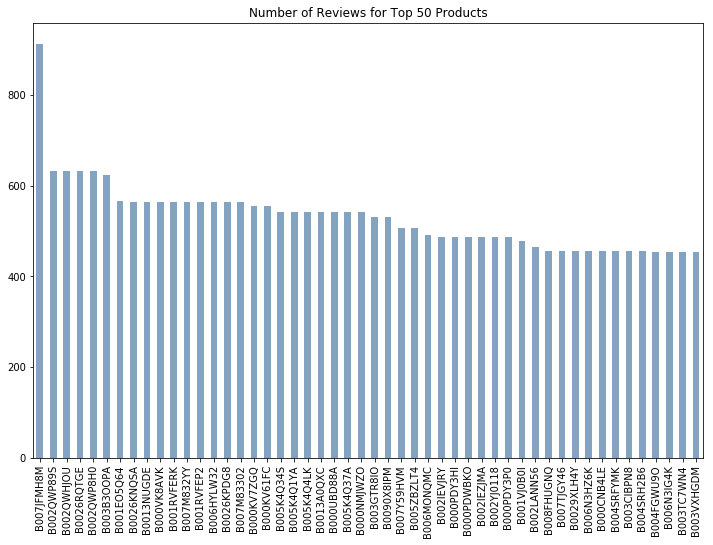

In [6]:
# Plot number of reviews for top 50 products
products = df["ProductId"].value_counts()
plt.figure(figsize=(12,8))
products[:50].plot(kind='bar', color=(0.2, 0.4, 0.6, 0.6))
plt.title("Number of Reviews for Top 50 Products")

Text(0,0.5,'Count')

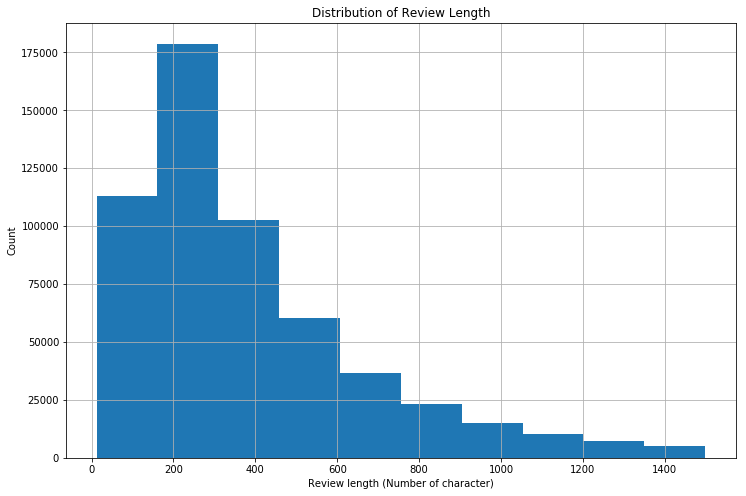

In [7]:
# Plot distribution of review length
review_length = df["Text"].dropna().map(lambda x: len(x))
plt.figure(figsize=(12,8))
review_length.loc[review_length < 1500].hist()
plt.title("Distribution of Review Length")
plt.xlabel('Review length (Number of character)')
plt.ylabel('Count')

---
<a id="part2"></a>
## Part 2. Data Preparation

*20% of the data in this project. 

*positive sentiment (rating = 4, 5)

*negative sentiment (rating = 1, 2)

*drop reviews with neutral sentiment (rating 3). 


### Prepare Data

In [21]:
df = df.sample(frac=0.2, random_state=0) 
df.dropna(inplace=True)
df = df[df['Score'] != 3]
df['Sentiment'] = np.where(df['Score'] > 3, 1, 0)
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment
178498,178499,B001BBYCW4,A2KCQSLGPMP0U0,Cheryl,0,0,5,1322697600,Best Mints EVER,I just got back from Amsterdam. These mints wh...,1
561429,561430,B004SKVWNW,A11NFITPY4FH42,Ryan,3,3,4,1328486400,Formula review,My wife breastfed for 6 months before we had t...,1
366353,366354,B005MER0RA,A2GR8ZOV24W263,jazz,0,0,5,1328140800,salt of the earth,What a fine product! I do not think I can ever...,1
521533,521534,B000LKUTN2,A2XL6TZM34HFV3,"Review Man ""Review Man""",3,3,5,1239235200,Very good gluten free pasta,We know all about gluten free foods and this b...,1
51633,51634,B002U5E30G,A1O5EEEAHCA2PE,mel@NY,0,0,5,1282262400,you would not notice that is sugar free !!!,"This black cherry soda is really good, the tas...",1


### Train Test Split 

In [9]:
# Split data into training set and validation
X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['Sentiment'], \
                                                    test_size=0.2, random_state=0)

print('Load %d training examples and %d validation examples. \n' %(X_train.shape[0],X_test.shape[0]))
print('Show a review in the training set : \n', X_train.iloc[10])

Load 84192 training examples and 21049 validation examples. 

Show a review in the training set : 
 This soda is OK. It has a weird aftertaste. The other flavors are actually really good. Grape is good and the Root Beer is good as well. You also can't even taste the natural sweetener, but with the regular COLA flavor you can definitely taste it. The Root Beer also tastes like Birch Beer, which I really like.<br /><br />The soda is also really expensive (over 1 dollar a can). Which is not really cost effective. Its much better to simply give up soda.


---
<a id="part3"></a>
## Part 3. Bag of Words

### Text Preprocessing

In [10]:
def cleanText(raw_text, remove_stopwords=False, stemming=False, split_text=False, \
             ):
    '''
    Convert a raw review to a cleaned review
    '''
    text = BeautifulSoup(raw_text, 'html.parser').get_text()  #remove html
    letters_only = re.sub("[^a-zA-Z]", " ", text)  # remove non-character
    words = letters_only.lower().split() # convert to lower case 
    
    if remove_stopwords: # remove stopword
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
        
    if stemming==True: # stemming
#         stemmer = PorterStemmer()
        stemmer = SnowballStemmer('english') 
        words = [stemmer.stem(w) for w in words]
        
    if split_text==True:  # split text
        return (words)
    
    return( " ".join(words)) 

In [11]:
# Preprocess text data in training set and validation set
X_train_cleaned = []
X_test_cleaned = []

for d in X_train:
    X_train_cleaned.append(cleanText(d))
print('Show a cleaned review in the training set : \n',  X_train_cleaned[10])
    
for d in X_test:
    X_test_cleaned.append(cleanText(d))

Show a cleaned review in the training set : 
 this soda is ok it has a weird aftertaste the other flavors are actually really good grape is good and the root beer is good as well you also can t even taste the natural sweetener but with the regular cola flavor you can definitely taste it the root beer also tastes like birch beer which i really like the soda is also really expensive over dollar a can which is not really cost effective its much better to simply give up soda


### CountVectorizer with Multinomial Naive Bayes (Benchmark Model)

In [80]:
# Fit and transform the training data to a document-term matrix using CountVectorizer
countVect = CountVectorizer() 
X_train_countVect = countVect.fit_transform(X_train_cleaned)
print("Number of features : %d \n" %len(countVect.get_feature_names())) #6378 
print("Show some feature names : \n", countVect.get_feature_names()[::1000])


# Train MultinomialNB classifier
mnb = MultinomialNB()
mnb.fit(X_train_countVect, y_train)

Number of features : 52657 

Show some feature names : 
 ['aa', 'ailments', 'anyhting', 'aw', 'beluga', 'bonsaiboy', 'burdened', 'casein', 'chiptole', 'col', 'contrived', 'crystaal', 'delectible', 'disassembled', 'drown', 'enemy', 'expeditious', 'finest', 'framework', 'genovese', 'grassiness', 'harrogate', 'hopped', 'inconvenience', 'isatori', 'kenkxa', 'leavesphoto', 'lovelier', 'mashup', 'mind', 'multimillion', 'nonpareils', 'ones', 'packwhat', 'pericone', 'pof', 'privacy', 'quinine', 'regardingziggle', 'ribes', 'sandra', 'seratonin', 'site', 'soreness', 'steampunk', 'sundown', 'tastfully', 'thos', 'treatakc', 'unfortunatey', 'vertebral', 'weren', 'xanthan']


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [81]:
def modelEvaluation(predictions):
    '''
    Print model evaluation to predicted result 
    '''
    print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test, predictions)))
    print("\nAUC score : {:.4f}".format(roc_auc_score(y_test, predictions)))
    print("\nClassification report : \n", metrics.classification_report(y_test, predictions))
    print("\nConfusion Matrix : \n",metrics.confusion_matrix(y_test, predictions) )

In [92]:
def modelTrainEvaluation(predictions):
    '''
    Print model evaluation to predicted result 
    '''
    print ("\nAccuracy on train set: {:.4f}".format(accuracy_score(y_train, predictions)))
    print("\nAUC score : {:.4f}".format(roc_auc_score(y_train, predictions)))
    print("\nClassification report : \n", metrics.classification_report(y_train, predictions))
    print("\nConfusion Matrix : \n",metrics.confusion_matrix(y_train, predictions) )

In [93]:
# Evaluate the model on validaton set
predictionstr = mnb.predict(countVect.transform(X_train_cleaned))
modelTrainEvaluation(predictionstr)
predictions = mnb.predict(countVect.transform(X_test_cleaned))
modelEvaluation(predictions)


Accuracy on train set: 0.9252

AUC score : 0.8509

Classification report : 
              precision    recall  f1-score   support

          0       0.77      0.74      0.76     13307
          1       0.95      0.96      0.96     70885

avg / total       0.92      0.93      0.92     84192


Confusion Matrix : 
 [[ 9878  3429]
 [ 2868 68017]]

Accuracy on validation set: 0.9144

AUC score : 0.8136

Classification report : 
              precision    recall  f1-score   support

          0       0.73      0.67      0.70      3145
          1       0.94      0.96      0.95     17904

avg / total       0.91      0.91      0.91     21049


Confusion Matrix : 
 [[ 2107  1038]
 [  764 17140]]


### TfidfVectorizer with Logistic Regression

In [95]:
# Fit and transform the training data to a document-term matrix using TfidfVectorizer 
tfidf = TfidfVectorizer(min_df=5) #minimum document frequency of 5
X_train_tfidf = tfidf.fit_transform(X_train)
print("Number of features : %d \n" %len(tfidf.get_feature_names())) #1722
print("Show some feature names : \n", tfidf.get_feature_names()[::1000])

# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)

Number of features : 17196 

Show some feature names : 
 ['00', 'antler', 'bore', 'chunky', 'custards', 'dumping', 'fishiness', 'guessed', 'instructed', 'lookout', 'muy', 'patterns', 'punish', 'rotting', 'smucker', 'sweats', 'ugly', 'wp']


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [96]:
# Look at the top 10 features with smallest and the largest coefficients
feature_names = np.array(tfidf.get_feature_names())
sorted_coef_index = lr.coef_[0].argsort()
print('\nTop 10 features with smallest coefficients :\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Top 10 features with largest coefficients : \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))


Top 10 features with smallest coefficients :
['worst' 'not' 'terrible' 'disappointed' 'disappointing' 'unfortunately'
 'horrible' 'awful' 'weak' 'disappointment']

Top 10 features with largest coefficients : 
['great' 'best' 'delicious' 'love' 'perfect' 'good' 'excellent' 'loves'
 'nice' 'wonderful']


In [97]:
# Evaluate on the validaton set
predictions = lr.predict(tfidf.transform(X_train_cleaned))
modelTrainEvaluation(predictions)

predictions = lr.predict(tfidf.transform(X_test_cleaned))
modelEvaluation(predictions)


Accuracy on train set: 0.9355

AUC score : 0.8276

Classification report : 
              precision    recall  f1-score   support

          0       0.90      0.67      0.77     13307
          1       0.94      0.99      0.96     70885

avg / total       0.93      0.94      0.93     84192


Confusion Matrix : 
 [[ 8913  4394]
 [ 1034 69851]]

Accuracy on validation set: 0.9312

AUC score : 0.8112

Classification report : 
              precision    recall  f1-score   support

          0       0.86      0.64      0.74      3145
          1       0.94      0.98      0.96     17904

avg / total       0.93      0.93      0.93     21049


Confusion Matrix : 
 [[ 2013  1132]
 [  316 17588]]


### Pipeline and GridSearch

In [ ]:
# Building a pipeline
estimators = [("tfidf", TfidfVectorizer()), ("lr", LogisticRegression())]
model = Pipeline(estimators)


# Grid search
params = {"lr__C":[0.1, 1, 10], #regularization param of logistic regression
          "tfidf__min_df": [1, 3], #min count of words 
          "tfidf__max_features": [1000, None], #max features
          "tfidf__ngram_range": [(1,1), (1,2)], #1-grams or 2-grams
          "tfidf__stop_words": [None, "english"]} #use stopwords or don't

grid = GridSearchCV(estimator=model, param_grid=params, scoring="accuracy", n_jobs=-1)
grid.fit(X_train_cleaned, y_train)
print("The best paramenter set is : \n", grid.best_params_)


# Evaluate on the validaton set
predictions = grid.predict(X_test_cleaned)
modelEvaluation(predictions)

In [ ]:
predictions = grid.predict(X_train_cleaned)
modelTrainEvaluation(predictions)

---
<a id="part4"></a>
## Part 4. Word2Vec

### Parsing Review into Sentences

In [12]:
# Split review text into parsed sentences uisng NLTK's punkt tokenizer
# nltk.download()
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

def parseSent(review, tokenizer, remove_stopwords=False):
    '''
    Parse text into sentences
    '''
    raw_sentences = tokenizer.tokenize(review.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(cleanText(raw_sentence, remove_stopwords, split_text=True))
    return sentences


# Parse each review in the training set into sentences
sentences = []
for review in X_train_cleaned:
    sentences += parseSent(review, tokenizer)
    
print('%d parsed sentence in the training set\n'  %len(sentences))
print('Show a parsed sentence in the training set : \n',  sentences[10])

84192 parsed sentence in the training set

Show a parsed sentence in the training set : 
 ['this', 'soda', 'is', 'ok', 'it', 'has', 'a', 'weird', 'aftertaste', 'the', 'other', 'flavors', 'are', 'actually', 'really', 'good', 'grape', 'is', 'good', 'and', 'the', 'root', 'beer', 'is', 'good', 'as', 'well', 'you', 'also', 'can', 't', 'even', 'taste', 'the', 'natural', 'sweetener', 'but', 'with', 'the', 'regular', 'cola', 'flavor', 'you', 'can', 'definitely', 'taste', 'it', 'the', 'root', 'beer', 'also', 'tastes', 'like', 'birch', 'beer', 'which', 'i', 'really', 'like', 'the', 'soda', 'is', 'also', 'really', 'expensive', 'over', 'dollar', 'a', 'can', 'which', 'is', 'not', 'really', 'cost', 'effective', 'its', 'much', 'better', 'to', 'simply', 'give', 'up', 'soda']


### Creating Volcabulary List usinhg Word2Vec Model

In [13]:
# Fit parsed sentences to Word2Vec model 
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',level=logging.INFO)

num_features = 300  #embedding dimension                     
min_word_count = 10                
num_workers = 4       
context = 10                                                                                          
downsampling = 1e-3 

print("Training Word2Vec model ...\n")
w2v = Word2Vec(sentences, workers=num_workers, size=num_features, min_count = min_word_count,\
                 window = context, sample = downsampling)
w2v.init_sims(replace=True)
w2v.save("w2v_300features_10minwordcounts_10context") #save trained word2vec model

print("Number of words in the vocabulary list : %d \n" %len(w2v.wv.index2word)) #4016 
print("Show first 10 words in the vocalbulary list  vocabulary list: \n", w2v.wv.index2word[0:10])

Training Word2Vec model ...

Number of words in the vocabulary list : 12318 

Show first 10 words in the vocalbulary list  vocabulary list: 
 ['the', 'i', 'and', 'a', 'it', 'to', 'of', 'is', 'this', 'for']


### Averaging Feature Vectors

In [107]:
# Transfrom the training data into feature vectors

def makeFeatureVec(review, model, num_features):
    '''
    Transform a review to a feature vector by averaging feature vectors of words 
    appeared in that review and in the volcabulary list created
    '''
    featureVec = np.zeros((num_features,),dtype="float32")
    nwords = 0.
    index2word_set = set(model.wv.index2word) #index2word is the volcabulary list of the Word2Vec model
    isZeroVec = True
    for word in review:
        if word in index2word_set: 
            nwords = nwords + 1.
            featureVec = np.add(featureVec, model[word])
            isZeroVec = False
    if isZeroVec == False:
        featureVec = np.divide(featureVec, nwords)
    return featureVec


def getAvgFeatureVecs(reviews, model, num_features):
    '''
    Transform all reviews to feature vectors using makeFeatureVec()
    '''
    counter = 0
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    for review in reviews:
        reviewFeatureVecs[counter] = makeFeatureVec(review, model,num_features)
        counter = counter + 1
    return reviewFeatureVecs

In [108]:
# Get feature vectors for training set
X_train_cleaned = []
for review in X_train:
    X_train_cleaned.append(cleanText(review, remove_stopwords=True, split_text=True))
trainVector = getAvgFeatureVecs(X_train_cleaned, w2v, num_features)
print("Training set : %d feature vectors with %d dimensions" %trainVector.shape)


# Get feature vectors for validation set
X_test_cleaned = []
for review in X_test:
    X_test_cleaned.append(cleanText(review, remove_stopwords=True, split_text=True))
testVector = getAvgFeatureVecs(X_test_cleaned, w2v, num_features)
print("Validation set : %d feature vectors with %d dimensions" %testVector.shape)


# debugging
# print("Checkinf for NaN and Inf")
# print("np.inf=", np.where(np.isnan(trainVector)))
# print("is.inf=", np.where(np.isinf(trainVector)))
# print("np.max=", np.max(abs(trainVector)))

/home/varuni/anaconda3/envs/mlearn/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app


Training set : 84192 feature vectors with 300 dimensions
Validation set : 21049 feature vectors with 300 dimensions


### Random Forest Classifer

In [109]:
# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100)
rf.fit(trainVector, y_train)
predictions = rf.predict(testVector)
modelEvaluation(predictions)


Accuracy on validation set: 0.9148

AUC score : 0.7431

Classification report : 
              precision    recall  f1-score   support

          0       0.88      0.50      0.64      3145
          1       0.92      0.99      0.95     17904

avg / total       0.91      0.91      0.90     21049


Confusion Matrix : 
 [[ 1567  1578]
 [  216 17688]]


In [115]:
predictions = rf.predict(trainVector)
modelTrainEvaluation(predictions)


Accuracy on train set: 1.0000

AUC score : 0.9999

Classification report : 
              precision    recall  f1-score   support

          0       1.00      1.00      1.00     13307
          1       1.00      1.00      1.00     70885

avg / total       1.00      1.00      1.00     84192


Confusion Matrix : 
 [[13305     2]
 [    1 70884]]


---
<a id="part5"></a>
## Part 5. LSTM

### Simple LSTM

In [111]:
top_words = 20000 
maxlen = 100 
batch_size = 32
nb_classes = 2
nb_epoch = 3


# Vectorize X_train and X_test to 2D tensor
tokenizer = Tokenizer(num_words=top_words) #only consider top 20000 words in the corpse
tokenizer.fit_on_texts(X_train)
# tokenizer.word_index #access word-to-index dictionary of trained tokenizer

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

X_train_seq = sequence.pad_sequences(sequences_train, maxlen=maxlen)
X_test_seq = sequence.pad_sequences(sequences_test, maxlen=maxlen)


# one-hot encoding of y_train and y_test
y_train_seq = np_utils.to_categorical(y_train, nb_classes)
y_test_seq = np_utils.to_categorical(y_test, nb_classes)

print('X_train shape:', X_train_seq.shape) #(27799, 100)
print('X_test shape:', X_test_seq.shape) #(3089, 100)
print('y_train shape:', y_train_seq.shape) #(27799, 2)
print('y_test shape:', y_test_seq.shape) #(3089, 2)

X_train shape: (84192, 100)
X_test shape: (21049, 100)
y_train shape: (84192, 2)
y_test shape: (21049, 2)


In [112]:
# Construct a simple LSTM
model1 = Sequential()
model1.add(Embedding(top_words, 128))
model1.add(SpatialDropout1D(0.2))
model1.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2)) 
model1.add(Dense(nb_classes))
model1.add(Activation('softmax'))
model1.summary()

# Compile LSTM
model1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model1.fit(X_train_seq, y_train_seq, batch_size=batch_size, epochs=nb_epoch, verbose=1)

# Model evluation
score = model1.evaluate(X_test_seq, y_test_seq, batch_size=batch_size)
model1.save("lstm.h5")
print('Test loss : {:.4f}'.format(score[0]))
print('Test accuracy : {:.4f}'.format(score[1]))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, None, 128)         0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
_________________________________________________________________
activation_3 (Activation)    (None, 2)                 0         
Total params: 2,691,842
Trainable params: 2,691,842
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
84192/84192 [==============================] - 1323s 16ms/step - loss: 0.2472 - acc: 0.9031
Epoch 2/3
84192/84192 [=======

In [18]:
from keras.models import load_model
model4 = load_model('lstm.h5')

y_pred = model4.predict(X_test_seq)
y_pred = (y_pred > 0.5)


### LSTM with Word2Vec Embedding

In [14]:
# Load trained Word2Vec model
w2v = Word2Vec.load("w2v_300features_10minwordcounts_10context")


# Get Word2Vec embedding matrix
embedding_matrix = w2v.wv.vectors  # embedding matrix, type = numpy.ndarray 
print("Shape of embedding matrix : ", embedding_matrix.shape) #(4016, 300) = (volcabulary size, embedding dimension)
# w2v.wv.syn0[0] #feature vector of the first word in the volcabulary list

Shape of embedding matrix :  (12318, 300)


In [15]:
top_words = embedding_matrix.shape[0] #4016
maxlen = 100 
batch_size = 32
nb_classes = 2
nb_epoch = 3


# Vectorize X_train and X_test to 2D tensor
tokenizer = Tokenizer(num_words=top_words) #only consider top 20000 words in the corpse
tokenizer.fit_on_texts(X_train)
# tokenizer.word_index #access word-to-index dictionary of trained tokenizer

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

X_train_seq = sequence.pad_sequences(sequences_train, maxlen=maxlen)
X_test_seq = sequence.pad_sequences(sequences_test, maxlen=maxlen)


# one-hot encoding of y_train and y_test
y_train_seq = np_utils.to_categorical(y_train, nb_classes)
y_test_seq = np_utils.to_categorical(y_test, nb_classes)

print('X_train shape:', X_train_seq.shape) #(27799, 100)
print('X_test shape:', X_test_seq.shape) #(3089, 100)
print('y_train shape:', y_train_seq.shape) #(27799, 2)
print('y_test shape:', y_test_seq.shape) #(3089, 2)

X_train shape: (84192, 100)
X_test shape: (21049, 100)
y_train shape: (84192, 2)
y_test shape: (21049, 2)


In [16]:
# Construct Word2Vec embedding layer
embedding_layer = Embedding(embedding_matrix.shape[0], #4016
                            embedding_matrix.shape[1], #300
                            weights=[embedding_matrix])


# Construct LSTM with Word2Vec embedding
model2 = Sequential()
model2.add(embedding_layer)
model2.add(LSTM(128, dropout_W=0.2, dropout_U=0.2
               )) 
model2.add(Dense(nb_classes))
model2.add(Activation('softmax'))
model2.summary()

# Compile model
model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model2.fit(X_train_seq, y_train_seq, batch_size=batch_size, epochs  =nb_epoch, verbose=1)


# Model evaluation
score = model2.evaluate(X_test_seq, y_test_seq, batch_size=batch_size)
model2.save("lstmw2.h5")
print('Test loss : {:.4f}'.format(score[0]))
print('Test accuracy : {:.4f}'.format(score[1]))

/home/varuni/anaconda3/envs/mlearn/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, dropout=0.2, recurrent_dropout=0.2)`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         3695400   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
_________________________________________________________________
activation_1 (Activation)    (None, 2)                 0         
Total params: 3,915,306
Trainable params: 3,915,306
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
84192/84192 [==============================] - 1881s 22ms/step - loss: 0.2368 - acc: 0.9072
Epoch 2/3
84192/84192 [==============================] - 1766s 21ms/step - loss: 0.1349 - acc: 0.9492
Epoch 3/3
21049/21049 [==============================] - 112

In [37]:
# get weight matrix of the embedding layer
print("Size of weight matrix in the embedding layer : ", \
      model2.layers[0].get_weights()[0].shape) #(20000, 128)

# get weight matrix of the hidden layer
print("Size of weight matrix in the hidden layer : ", \
      model2.layers[1].get_weights()[0].shape) #(128, 512)  weight dim of LSTM - w

# get weight matrix of the output layer
print("Size of weight matrix in the output layer : ", \
      model2.layers[2].get_weights()[0].shape) #(128, 2) weight dim of dense layer

Size of weight matrix in the embedding layer :  (9338, 300)
Size of weight matrix in the hidden layer :  (300, 512)
Size of weight matrix in the output layer :  (128, 2)


In [113]:
from keras.models import load_model
model5 = load_model('lstmw2.h5')

X_eval = "So tasty and good. Satisfied. Amazing. Beautiful."
sequences_eval = tokenizer.texts_to_sequences(X_eval)
X_eval_seq =sequence.pad_sequences(sequences_eval, maxlen=maxlen)

sent = model5.predict(X_eval_seq)[0]
print(np.argmax(sent))

0


---
<a id="part6"></a>
## Part 6. Word Cloud

In this part, we create word clouds for positive sentiment reviews and negative sentiment reviews of a selected brand, to get an intuition of words frequently appear in different sentiments.

In [30]:
def create_word_cloud(sentiment):
    
        #df_brand = df.loc[df['Brand Name'].isin([brand])]
        df_brand_sample = df.sample(frac=0.01)
        word_cloud_collection = ''
        
        if sentiment == 1:
            df_reviews = df_brand_sample[df_brand_sample["Sentiment"]==1]["Text"]
            
        if sentiment == 0:
            df_reviews = df_brand_sample[df_brand_sample["Sentiment"]==0]["Text"]
            
        for val in df_reviews.str.lower():
            tokens = nltk.word_tokenize(val)
            tokens = [word for word in tokens if word not in stopwords.words('english') and word != "br"]
            for words in tokens:
                word_cloud_collection = word_cloud_collection + words + ' '

        wordcloud = WordCloud(max_font_size=50, width=500, height=300).generate(word_cloud_collection)
        plt.figure(figsize=(20,20))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()
    
        

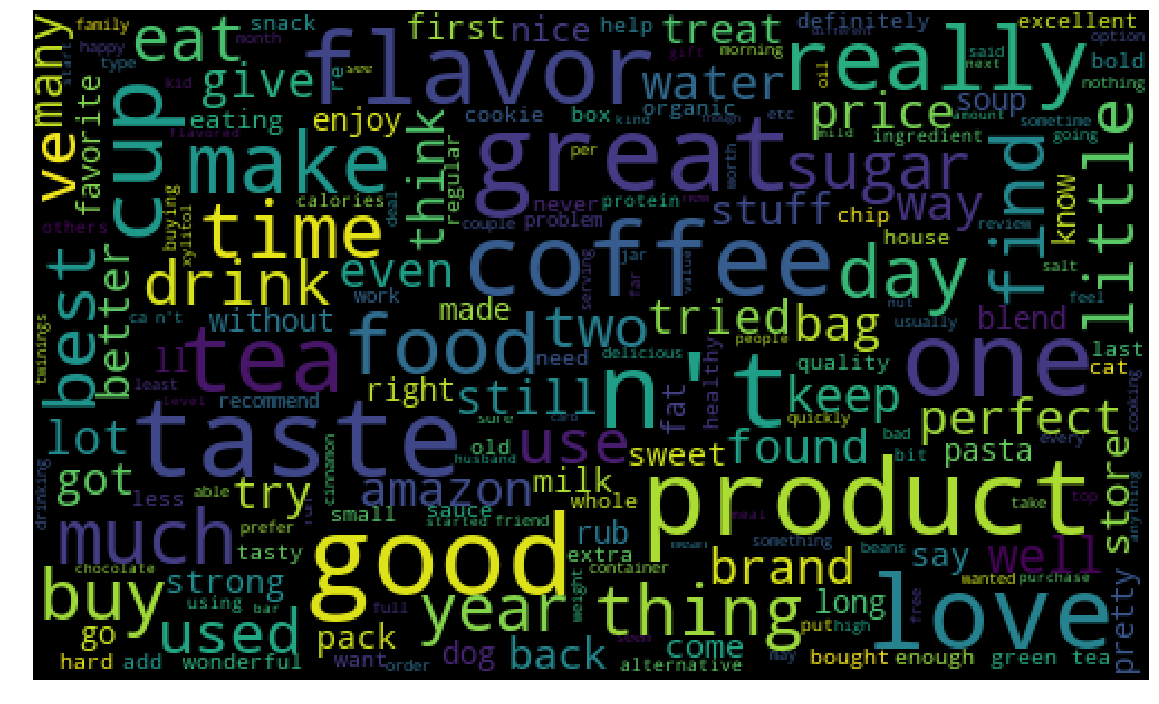

In [31]:
create_word_cloud(sentiment=1)

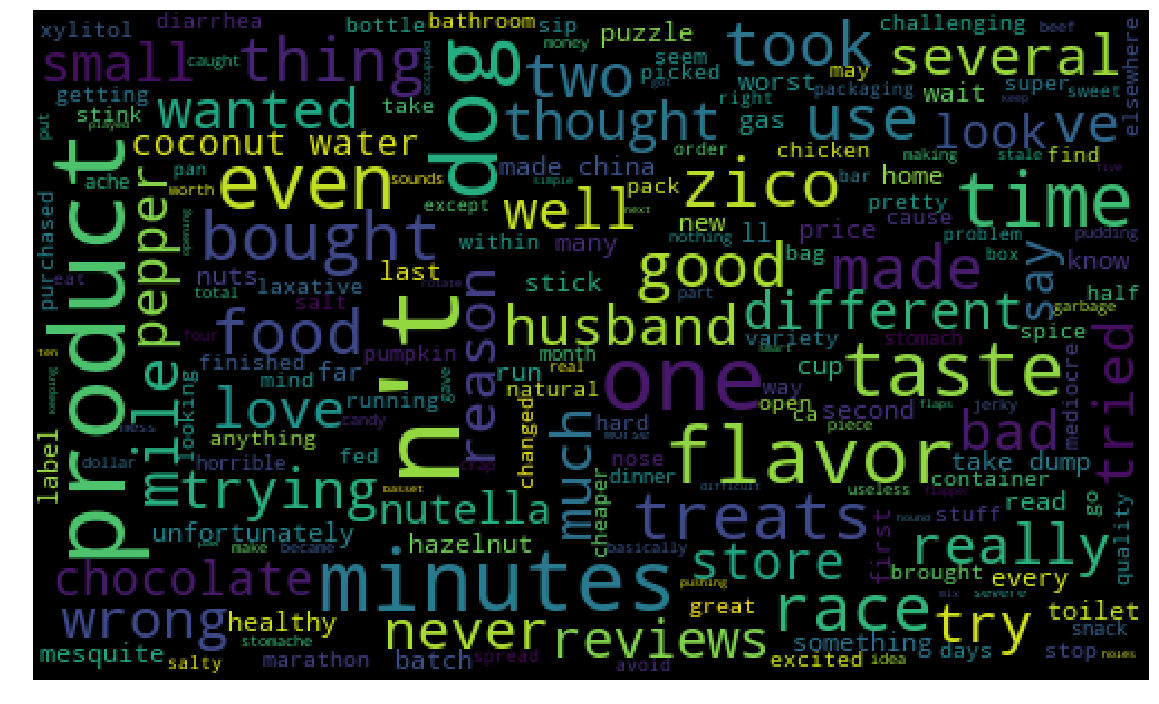

In [32]:
create_word_cloud(sentiment=0)